In [ ]:
!pip install qiskit
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

### Part A — Quantum Teleportation

Bell pair counts: {'11': 998, '00': 1050}


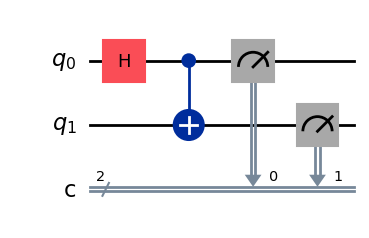

In [ ]:

# Qiskit ≥ 1.0
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Bell state on 2 qubits, measure both
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

backend = AerSimulator()
tqc = transpile(qc, backend)          # <-- replaces execute()
job = backend.run(tqc, shots=2048)    # <-- run the transpiled circuit
result = job.result()
counts = result.get_counts()
print("Bell pair counts:", counts)  # ~{'00': ~1024, '11': ~1024}, up to sampling noise

qc.draw('mpl')


In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

def bell_state(i):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    # modify based on index 0–3
    if i == 1: qc.z(0)       # Φ−
    elif i == 2: qc.x(1)     # Ψ+
    elif i == 3: qc.z(0); qc.x(1)  # Ψ−
    return Statevector.from_instruction(qc)

labels = ["Φ⁺", "Φ⁻", "Ψ⁺", "Ψ⁻"]
for i in range(4):
    psi = bell_state(i)
    print(f"|{labels[i]}> =", psi.data.round(3))


|Φ⁺> = [0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]
|Φ⁻> = [ 0.707+0.j -0.   +0.j  0.   +0.j -0.707+0.j]
|Ψ⁺> = [0.   +0.j 0.707+0.j 0.707+0.j 0.   +0.j]
|Ψ⁻> = [ 0.   +0.j -0.707+0.j  0.707+0.j -0.   +0.j]


In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity

def arbitrary_single_qubit(theta, phi):
    """Prepare |ψ> = cos(theta/2)|0> + e^{i phi} sin(theta/2)|1> on qubit 0 (in a 3q circuit)."""
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi,   0)
    return qc

def teleportation_unitary():
    """Teleport from qubit 0 to qubit 2 using unitary (deferred) corrections."""
    qc = QuantumCircuit(3)
    # Create Bell pair between qubits 1 and 2
    qc.h(1)
    qc.cx(1, 2)
    # Bell-basis operation on qubits 0 and 1
    qc.cx(0, 1)
    qc.h(0)
    # Deferred-measurement corrections: X^(m1)Z^(m0) → CX(1→2) then CZ(0→2)
    qc.cx(1, 2)
    qc.cz(0, 2)
    return qc

# --- Build full circuit: prepare |ψ> then teleport it to qubit 2
theta, phi = 1.1, 0.7
prep = arbitrary_single_qubit(theta, phi)
tele = teleportation_unitary()
full = prep.compose(tele)

# Final 3-qubit state after teleportation
psi_out = Statevector.from_instruction(full)

# Reduced state (destination qubit 2)
rho_2 = partial_trace(psi_out, [0, 1])            # DensityMatrix for qubit 2

# Ideal single-qubit |ψ> to compare against
qc_ideal = QuantumCircuit(1)
qc_ideal.ry(theta, 0)
qc_ideal.rz(phi,   0)
psi_ideal_1q = Statevector.from_label('0').evolve(qc_ideal)

# Fidelity between teleported output and the target |ψ>
F = state_fidelity(DensityMatrix(rho_2), psi_ideal_1q)
print(f"Teleportation fidelity ≈ {F:.6f}")  # ≈ 1.000000 in noiseless simulation


Teleportation fidelity ≈ 1.000000


### Sub-task 1 – Vary the Input State

In [9]:
# Testing different input states
for theta in [0, 1.1, 2.2, 3.3]:
    for phi in [0, 0.7, 1.4, 2.1]:
        # Prepare and teleport
        prep = arbitrary_single_qubit(theta, phi)
        tele = teleportation_unitary()
        full = prep.compose(tele)

        # Final 3-qubit state after teleportation
        psi_out = Statevector.from_instruction(full)

        # Reduced state (destination qubit 2)
        rho_2 = partial_trace(psi_out, [0, 1])            # DensityMatrix for qubit 2

        # Ideal single-qubit |ψ> to compare against
        qc_ideal = QuantumCircuit(1)
        qc_ideal.ry(theta, 0)
        qc_ideal.rz(phi,   0)
        psi_ideal_1q = Statevector.from_label('0').evolve(qc_ideal)

        # Fidelity between teleported output and the target |ψ>
        F = state_fidelity(DensityMatrix(rho_2), psi_ideal_1q)
        print(f"Theta: {theta:.1f}, Phi: {phi:.1f} => Teleportation fidelity ≈ {F:.6f}")

Theta: 0.0, Phi: 0.0 => Teleportation fidelity ≈ 1.000000
Theta: 0.0, Phi: 0.7 => Teleportation fidelity ≈ 1.000000
Theta: 0.0, Phi: 1.4 => Teleportation fidelity ≈ 1.000000
Theta: 0.0, Phi: 2.1 => Teleportation fidelity ≈ 1.000000
Theta: 1.1, Phi: 0.0 => Teleportation fidelity ≈ 1.000000
Theta: 1.1, Phi: 0.7 => Teleportation fidelity ≈ 1.000000
Theta: 1.1, Phi: 1.4 => Teleportation fidelity ≈ 1.000000
Theta: 1.1, Phi: 2.1 => Teleportation fidelity ≈ 1.000000
Theta: 2.2, Phi: 0.0 => Teleportation fidelity ≈ 1.000000
Theta: 2.2, Phi: 0.7 => Teleportation fidelity ≈ 1.000000
Theta: 2.2, Phi: 1.4 => Teleportation fidelity ≈ 1.000000
Theta: 2.2, Phi: 2.1 => Teleportation fidelity ≈ 1.000000
Theta: 3.3, Phi: 0.0 => Teleportation fidelity ≈ 1.000000
Theta: 3.3, Phi: 0.7 => Teleportation fidelity ≈ 1.000000
Theta: 3.3, Phi: 1.4 => Teleportation fidelity ≈ 1.000000
Theta: 3.3, Phi: 2.1 => Teleportation fidelity ≈ 1.000000


Question: Does teleportation depend on what state Alice starts with?

In a noiseless scenario, the answer is no. The teleportation protocol works for any arbitrary single-qubit state that Alice wants to send to Bob.


The reason is that the teleportation protocol is designed to transfer the full quantum information of the qubit, regardless of its initial state.

### Sub-task 2 – Noise and Fidelity Check

In [ ]:
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
)

### Create a noise model

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']
Noisy Bell pair counts: {'00': 976, '11': 1072}


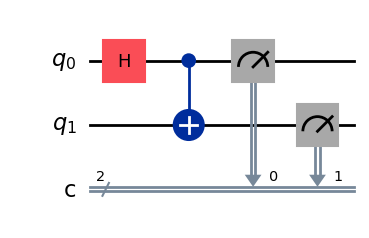

In [ ]:
# Create an empty noise model
noise_model = NoiseModel()
 
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.5, 1)
noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
 
# Print noise model info
print(noise_model)

# Add to the previous teleportation simulation
backend = AerSimulator(noise_model=noise_model)